# L1 regression of mean energy consumption

In [7]:
 # data and numbers
import numpy as np
import pandas as pd
import datetime as dt

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import ticker
import matplotlib.dates as mdates
%matplotlib inline

import pandas as pd
from sklearn import preprocessing

In [8]:
path_raw = "..//data//meters//raw//"
path_meta = "..//data//metadata//"
path_cleaned = "..//data//meters//cleaned//"

In [9]:
columns_to_use = [
    "building_id",
    #"site_id",
    "sqm",
    "lat",
    "lng",
    #"timezone",
    "industry",
    "subindustry",
    "heatingtype",
    #"yearbuilt",
    #"date_opened",
    #"numberoffloors",
]

In [10]:
meta = pd.read_csv(
    path_meta + "metadata.csv",
    usecols=columns_to_use,
    index_col="building_id"
)

meta_base = meta.copy()

# replace missing values in "industry" and "subindustry" columns with "None"
meta["industry"].fillna("None", inplace=True)
meta["subindustry"].fillna("None", inplace=True)
meta["heatingtype"].fillna("None", inplace=True)

meta = pd.get_dummies(meta)
meta.info()
meta.head()

def import_data(metername):
    # load data
    df = pd.read_csv(path_cleaned + metername + ".csv")
    
    # Transform timestamp to datetime object type
    df["timestamp"] = pd.to_datetime(df["timestamp"], format="%Y-%m-%d %H:%M:%S")
    df.set_index("timestamp", inplace=True)
    df.info()
    return df

sensor_data = import_data("electricity_cleaned")

# from meta, drop rows that are not in sensor_data index
meta = meta[meta.index.isin(sensor_data.columns)]

# standardize the data
scaler = preprocessing.StandardScaler()
meta_scaled = scaler.fit_transform(meta)
meta_scaled = pd.DataFrame(meta_scaled, columns=meta.columns, index=meta.index)
meta_scaled.head()


# split meta into train and test with sklearn
from sklearn.model_selection import train_test_split
train, test = train_test_split(meta_scaled, test_size=0.2, random_state=42)

/tmp/ipykernel_268428/405337224.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  meta["industry"].fillna("None", inplace=True)
/tmp/ipykernel_268428/405337224.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try

<class 'pandas.core.frame.DataFrame'>
Index: 1636 entries, Panther_lodging_Dean to Mouse_science_Micheal
Data columns (total 34 columns):
 #   Column                                             Non-Null Count  Dtype  
---  ------                                             --------------  -----  
 0   sqm                                                1636 non-null   float64
 1   lat                                                1399 non-null   float64
 2   lng                                                1399 non-null   float64
 3   industry_Education                                 1636 non-null   bool   
 4   industry_Government                                1636 non-null   bool   
 5   industry_Healthcare                                1636 non-null   bool   
 6   industry_Hospitality                               1636 non-null   bool   
 7   industry_None                                      1636 non-null   bool   
 8   subindustry_Animal Control                         1636 n

In [11]:
mean_sensor_data = sensor_data.mean()
mean_sensor_data.info()
print(mean_sensor_data)


<class 'pandas.core.series.Series'>
Index: 1578 entries, Panther_parking_Lorriane to Mouse_science_Micheal
Series name: None
Non-Null Count  Dtype  
--------------  -----  
1572 non-null   float64
dtypes: float64(1)
memory usage: 89.2+ KB
Panther_parking_Lorriane      10.722723
Panther_lodging_Cora         135.054565
Panther_office_Hannah          6.683938
Panther_lodging_Hattie       140.593488
Panther_education_Teofila    156.466222
                                ...    
Mouse_lodging_Vicente         45.767561
Mouse_health_Justin          783.350343
Mouse_health_Ileana           43.587324
Mouse_health_Estela          384.684218
Mouse_science_Micheal        435.844964
Length: 1578, dtype: float64


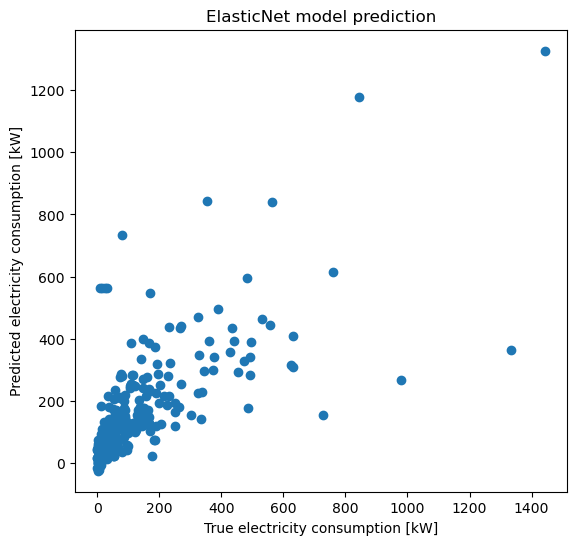

Most important features:


sqm                                                  162.292285
lat                                                   22.584882
heatingtype_District Heating                           9.048579
heatingtype_Heat network                               8.980786
heatingtype_Heat network and steam                     6.429318
subindustry_Laboratory                                 3.373680
subindustry_College/University                         1.437939
heatingtype_Oil                                        0.812615
subindustry_Water & Wastewater Treatment Facility      0.079389
heatingtype_None                                       0.000000
heatingtype_Heat network but not ours                  0.000000
heatingtype_Gas Boilers                               -0.000000
heatingtype_Electricity                                0.000000
heatingtype_Electric                                  -0.000000
heatingtype_Boiler fed central heating                -0.000000
dtype: float64

In [16]:
#Impute the NaN values in train and test
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imputer = IterativeImputer()
train_imputed = imputer.fit_transform(train)
test_imputed = imputer.transform(test)

train_imputed = pd.DataFrame(train_imputed, columns=train.columns)
test_imputed = pd.DataFrame(test_imputed, columns=test.columns)

train_imputed.index = train.index
test_imputed.index = test.index

#train_imputed.head()

train = train_imputed
test = test_imputed

train["mean_sensor_data"] = mean_sensor_data
test["mean_sensor_data"] = mean_sensor_data

train.dropna(inplace=True)
test.dropna(inplace=True)



#train.info()
#train.head()

# Train linear regression model using L1 regularization on dataframe train, where column mean_sensor_data is the target
from sklearn.linear_model import Lasso, ElasticNet

lasso_model = Lasso(alpha=1)
lasso_model.fit(train.drop(columns=["mean_sensor_data"]), train["mean_sensor_data"])

# Predict mean_sensor_data on test
predict = lasso_model.predict(test.drop(columns=["mean_sensor_data"]))
predict = pd.Series(predict, index=test.index)

# Visualize the results
plt.figure(figsize=(12, 6))
plt.scatter(test["mean_sensor_data"], predict)
plt.xlabel("True electricity consumption [kW]")
plt.ylabel("Predicted electricity consumption [kW]")
plt.title("ElasticNet model prediction")
# set axis equal
plt.gca().set_aspect("equal")
plt.show()

# Identify most important features
print("Most important features:")
feature_importance = pd.Series(lasso_model.coef_, index=train.drop(columns=["mean_sensor_data"]).columns)
feature_importance.sort_values(ascending=False, inplace=True)
feature_importance.head(15)

# Iterative imputer

